In [175]:
import torch
import torchvision
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import Counter
import time
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

In [2]:
# Set device, will make it such that it will run on GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset

full_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)



# PARTIE $I$

## 1. Données d'entrée

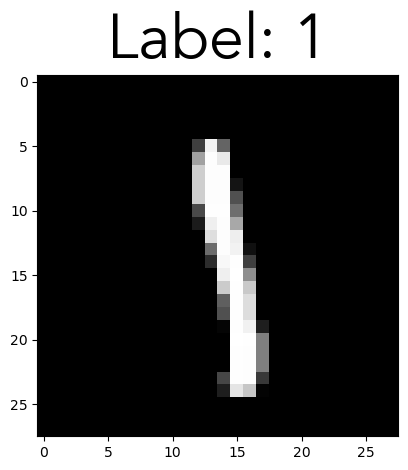

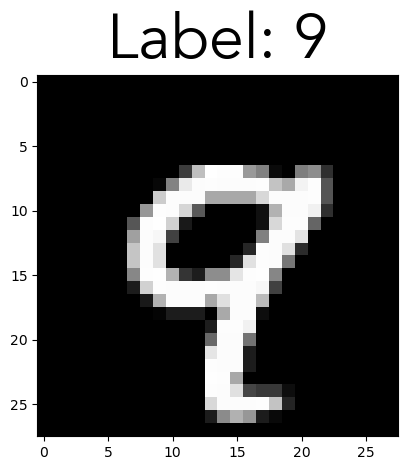

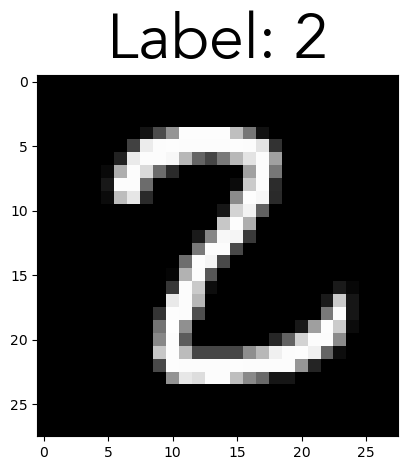

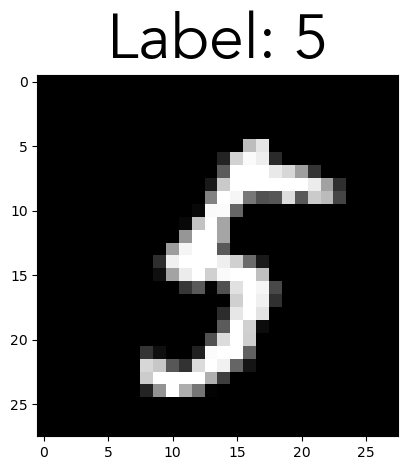

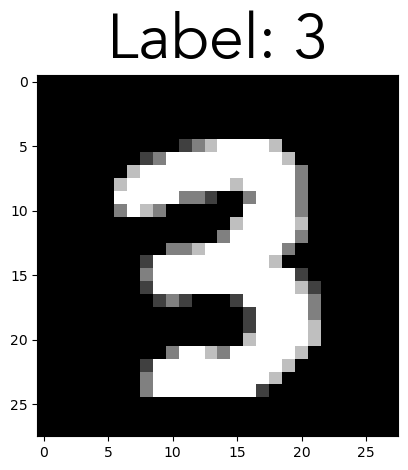

In [4]:
# 
# AFFICHER IMAGES DU DATASET
image_set = DataLoader(full_dataset, batch_size=50, shuffle=True)
images_from_set, labels_from_set = next(iter(image_set))
# print(images_from_set,labels_from_set)

# Visualisation des images du sous-ensemble
for pos,im in enumerate(image_set):
    if pos < 5:
        plt.imshow(images_from_set[pos][0].numpy() * 0.5 + 0.5, cmap='gray')  # Unnormalize for visualization
        plt.title(f"Label: {labels_from_set[pos]}", font='Avenir',size=45)
        plt.tight_layout()
        plt.savefig(f"./figures/p1e1_CNNset_im-{labels_from_set[pos]}.png",dpi=150)
        
        plt.show()

## 2. Distribution des étiquettes

[(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]
Occurences de 0 : 5923
Occurences de 1 : 6742
Occurences de 2 : 5958
Occurences de 3 : 6131
Occurences de 4 : 5842
Occurences de 5 : 5421
Occurences de 6 : 5918
Occurences de 7 : 6265
Occurences de 8 : 5851
Occurences de 9 : 5949


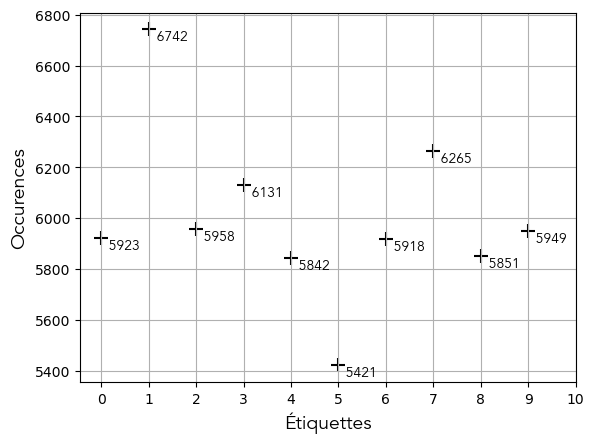

In [5]:
labels_set = full_dataset.targets

dist_count = Counter(labels_set.numpy())

print(sorted(dist_count.items()))
for label, occurence in sorted(dist_count.items()):
    print(f"Occurences de {label} : {occurence}")
    plt.text(label, occurence, f'  {occurence}', ha='left',va='top', font='Avenir', size=10)

    
plt.scatter(dist_count.keys(), dist_count.values(), color='black', marker="+", s=100)
plt.xticks(ticks=np.arange(0,11,1))
plt.xlabel('Étiquettes', font='Avenir',size=14)
plt.ylabel('Occurences', font='Avenir',size=14)
plt.grid()
plt.savefig(f"./figures/p1e2_Occ-f-Étiq.png",dpi=150)
plt.show()

## 3. Entraîner le CNN
### $\rightarrow$ Classes et fonctions
(Données avec le TP)

In [16]:
# Classifier model with CNN
class SimpleClassifier(nn.Module):
    
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Update dimensions if pooling changes output size
        self.fc2 = nn.Linear(128, 10)  # 10 classes (0–9)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + Pool
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Logits
        return x

modelCNN = SimpleClassifier().to(DEVICE)
print(modelCNN)

SimpleClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [17]:
# Training the classifier
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        #if (batch_idx + 1) % 100 == 0:
        #    print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

#### On va ajouter aux loops prédéfinies ce test qui produit la matrice de confusion et une table de contingence avant de faire rouler les tests. On aura ainsi les données nécessaires, relatives aux tests effectués plus tôt, pour les courbes ROC et les matrices de confusion (6) et (7).

### (6, 7 - Table de contingence et courbe ROC)

### Matrice de confusion systématique pour chaque classe

In [18]:
# Fonction modifiée, pour enregistrer les valeurs actuelles et prédites pour chaque classe

def test_matrice_confusion(model, test_loader, device):
    model.eval()
    predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Extraction des valeurs prédites et des vraies valeurs
            predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    #conversion des valeurs prédites et extraites en array numpy
    predictions = np.array(predictions)
    all_labels = np.array(all_labels)
    
    # Initialisation de la matrice de confusion (10 x 10) 
    num_classes = 10  # MNIST : 10 classes de 0 à 9
    
    cont_tb = np.zeros((num_classes, num_classes), dtype=int)
    
    # On ajoute 1 aux positions [t,p] de la matrice de confusion, 
    # où t est la véritée (truth)-> Le numéro de ligne,
    # et p la prédiction -> le numéro de colonne.
    for t, p in zip(all_labels, predictions):
        cont_tb[t, p] += 1
    
    # tables de contingence pour chaque classe cls (! veut dire 'not', dans mes commentaires)
    # dictionnaire de dictionnaires: cont_table a comme clef une classe, et comme valeur sa table de contingence
    
    conf_mxs = {}
    for cls in range(num_classes):
        TP = cont_tb[cls, cls] # t == cls, True Positive (TP)
        FP = cont_tb[:, cls].sum() - TP # Total des fausses prédictions, t != cls, False Positive (FP)
        FN = cont_tb[cls, :].sum() - TP # Total des ratés, p != cls, False Negative (FN)
        TN = cont_tb.sum() - (TP + FP + FN) # Total des correctement ignorés, t,p == !cls, True Negative (TN)
        
        conf_mxs[cls] = {
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN
        }
    
    return cont_tb, conf_mxs #Contingence Table, Confusion Matrixes

### $\rightarrow$ Itérations selon les tailles d'échantillons, pour l'ensemble du processus avec le CNN
(Step 3, 4 et 5 + Training Loop, fournies dans le TP)

In [19]:
# Prévoir sauvegarde des résultats pour discussion
performance=[] #Contiendra des listes de 3 valeurs: [%échantillon, loss, accuracy]
test_losses=[]
train_losses=[]

In [20]:
percent_scores={}
for percent in [0.1, 1,10,20,50,80]:
    # Message de début de traitement
    print("*"*50+"\n"+f"Initialisation avec {percent}% des données\n"+"*"*50)
    
    # Step 3: Split into Train/Validation/Test
    #Pourcentage de l'échantillon
    pct = percent/100
    #Organisation des tailles d'échantillons
    train_size = int(pct * len(full_dataset))  
    val_size = int(0.1 * len(full_dataset))    # 10% validation
    test_size = len(full_dataset) - train_size - val_size  # 10% test
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Step 4: Create DataLoaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Step 5: Verify the Split
    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")
#     print("\n"+30*"="+"\n")
    
    #Ajout de la Training Loop
    # Training loop
    num_epochs = 5
    best_test_accuracy = 0.0  # To track the best test accuracy
    best_epoch = 0  # To track the epoch with the best test accuracy
    
    # Message de début d'entraînement
    print("*"*50+"\n"+f"Entraînement avec {percent}% des données\n"+"*"*50)
    for epoch in range(num_epochs):
        # Train the model
        train_loss = train(modelCNN, train_loader, optimizer, criterion, DEVICE)

        # Evaluate on the test set during training
        test_loss, test_accuracy = test(modelCNN, test_loader, criterion, DEVICE)

        # Update the best model if the current test accuracy is better
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_epoch = epoch + 1
            torch.save(modelCNN.state_dict(), "best_model.pth")  # Save the best model

        # Print epoch results
        print(f"Epoch {epoch + 1}/{num_epochs}")
        #Pertes, entraînement
        print(f"Train Loss: {train_loss:.4f}")
        train_losses.append([epoch+1,train_loss])
        
        #Pertes, évaluation
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        test_losses.append([epoch+1, test_loss])
        
        
        #Pertes, entraînement
        print(f"Train Loss: {train_loss:.4f}")
        
        #Pertes, évaluation
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        print(f"Best Test Accuracy So Far: {best_test_accuracy:.2f}% (Epoch {best_epoch})")
        
    #AJOUT DES TABLES DE CONTINGENCES ET MATRICES DE CONFUSION POUR L'EPOCH
    print(f"\nTable de contingence pour {percent}% de l'échantillon")
    matrice_conf, cont_tables = test_matrice_confusion(modelCNN, test_loader, DEVICE)
    
    percent_scores[percent]={"m":matrice_conf,"c":cont_tables}
    
    print( percent_scores[percent]["m"],"\n",percent_scores[percent]["c"])
    # Load the best model for final validation evaluation
    print("\nLoading the best model for validation...")
    modelCNN.load_state_dict(torch.load("best_model.pth"))

    # Evaluate the final model on the validation set
    validation_loss, validation_accuracy = test(modelCNN, val_loader, criterion, DEVICE)
    print(f"\nFinal Validation Results - Loss: {validation_loss:.4f}, Accuracy: {validation_accuracy:.2f}%")

**************************************************
Initialisation avec 0.1% des données
**************************************************
Train set size: 60
Validation set size: 6000
Test set size: 53940
**************************************************
Entraînement avec 0.1% des données
**************************************************
Epoch 1/5
Train Loss: 2.3216
Test Loss: 2.3087, Test Accuracy: 10.49%
Train Loss: 2.3216
Test Loss: 2.3087, Test Accuracy: 10.49%
Best Test Accuracy So Far: 10.49% (Epoch 1)
Epoch 2/5
Train Loss: 2.1959
Test Loss: 2.3715, Test Accuracy: 10.49%
Train Loss: 2.1959
Test Loss: 2.3715, Test Accuracy: 10.49%
Best Test Accuracy So Far: 10.49% (Epoch 1)
Epoch 3/5
Train Loss: 2.1101
Test Loss: 2.4445, Test Accuracy: 10.49%
Train Loss: 2.1101
Test Loss: 2.4445, Test Accuracy: 10.49%
Best Test Accuracy So Far: 10.49% (Epoch 1)
Epoch 4/5
Train Loss: 2.0584
Test Loss: 2.4214, Test Accuracy: 10.49%
Train Loss: 2.0584
Test Loss: 2.4214, Test Accuracy: 10.49%
Best T

Epoch 5/5
Train Loss: 0.0206
Test Loss: 0.0575, Test Accuracy: 98.32%
Train Loss: 0.0206
Test Loss: 0.0575, Test Accuracy: 98.32%
Best Test Accuracy So Far: 98.32% (Epoch 5)

Table de contingence pour 20% de l'échantillon
[[4167    3   10    0    2    8   14    1   15    3]
 [   1 4696    7    3    4    0    0    7    1    1]
 [   1   15 4064    7   10    0    0   40    6    3]
 [   2    4   20 4151    0   20    0   30   25   15]
 [   0    7    1    0 4039    0    1   12    1   18]
 [   2    4    2   15    9 3748    9    1   13    6]
 [   5   14    2    0   26    8 4088    0   13    0]
 [   2   10    2    1    4    2    0 4334    3   22]
 [   4   24   24    5   20   16    5    8 3950   33]
 [   6    4    1    1   32    8    0   17    4 4058]] 
 {0: {'TP': 4167, 'FP': 23, 'FN': 56, 'TN': 37754}, 1: {'TP': 4696, 'FP': 85, 'FN': 24, 'TN': 37195}, 2: {'TP': 4064, 'FP': 69, 'FN': 82, 'TN': 37785}, 3: {'TP': 4151, 'FP': 32, 'FN': 116, 'TN': 37701}, 4: {'TP': 4039, 'FP': 107, 'FN': 40, 'TN': 

## 4. Entraîner le Linear Model
### $\rightarrow$ Classes et fonctions
(Données avec le TP, fonctions définies en 3)

In [21]:
# Classifier model with linear layers only
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        # Flatten the 28x28 input to a single vector of 784
        self.fc1 = nn.Linear(28 * 28, 512)  # Input layer
        self.fc2 = nn.Linear(512, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 128)  # Hidden layer 2
        self.fc4 = nn.Linear(128, 10)   # Output layer (10 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))   # First linear layer
        x = F.relu(self.fc2(x))   # Second linear layer
        x = F.relu(self.fc3(x))   # Third linear layer
        x = self.fc4(x)           # Output logits
        return x

modelLIN = LinearClassifier().to(DEVICE)
print(modelLIN)

LinearClassifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


### $\rightarrow$ Itérations selon les tailles d'échantillons, pour l'ensemble du processus 
(Step 3, 4 et 5 + Training Loop, fournies dans le TP)


In [22]:
# Prévoir sauvegarde des résultats pour discussion
performanceLin=[] #Contiendra des listes de 3 valeurs: [%échantillon, loss, accuracy]
test_lossesLin=[]
train_lossesLin=[]

In [23]:
#Entraînement du modèle linéaire pour 0,1% et 80% des données (pour question 4 et 5)
percent_scoresLIN={}

print("MODÈLE LINÉAIRE\n")
for percent in [0.1,80]:
    # Message de début de traitement
    print("*"*50+"\n"+f"Initialisation avec {percent}% des données\n"+"*"*50)
    
    # Step 3: Split into Train/Validation/Test
    #Pourcentage de l'échantillon
    pct = percent/100
    #Organisation des tailles d'échantillons
    train_size = int(pct * len(full_dataset))  
    val_size = int(0.1 * len(full_dataset))    # 10% validation
    test_size = len(full_dataset) - train_size - val_size  # 10% test
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Step 4: Create DataLoaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Step 5: Verify the Split
    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")
#     print("\n"+30*"="+"\n")
    
    #Ajout de la Training Loop
    # Training loop
    num_epochs = 5
    best_test_accuracy = 0.0  # To track the best test accuracy
    best_epoch = 0  # To track the epoch with the best test accuracy
    
    # Message de début d'entraînement
    print("*"*50+"\n"+f"Entraînement avec {percent}% des données\n"+"*"*50)
    for epoch in range(num_epochs):
        # Train the model
        train_loss = train(modelLIN, train_loader, optimizer, criterion, DEVICE)

        # Evaluate on the test set during training
        test_loss, test_accuracy = test(modelLIN, test_loader, criterion, DEVICE)

        # Update the best model if the current test accuracy is better
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_epoch = epoch + 1
            torch.save(modelLIN.state_dict(), "best_model.pth")  # Save the best model

        # Print epoch results
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        #Pertes, entraînement
        print(f"Train Loss: {train_loss:.4f}")
        train_lossesLin.append([epoch+1,train_loss])
        
        #Pertes, évaluation
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        test_lossesLin.append([epoch+1, test_loss])
        
        print(f"Best Test Accuracy So Far: {best_test_accuracy:.2f}% (Epoch {best_epoch})")
    
    #AJOUT DES TABLES DE CONTINGENCES ET MATRICES DE CONFUSION POUR L'EPOCH
    print(f"\nTable de contingence pour {percent}% de l'échantillon")
    matrice_conf, cont_tables = test_matrice_confusion(modelLIN, test_loader, DEVICE)
    
    percent_scoresLIN[percent]={"m":matrice_conf,"c":cont_tables}
    
    print( percent_scoresLIN[percent]["m"],"\n",percent_scoresLIN[percent]["c"])
    # Load the best model for final validation evaluation
    print("\nLoading the best model for validation...")
    modelLIN.load_state_dict(torch.load("best_model.pth"))

    # Evaluate the final model on the validation set
    validation_loss, validation_accuracy = test(modelLIN, val_loader, criterion, DEVICE)
    print(f"\nFinal Validation Results - Loss: {validation_loss:.4f}, Accuracy: {validation_accuracy:.2f}%")
    
    performanceLin.append([percent,validation_loss,validation_accuracy])

MODÈLE LINÉAIRE

**************************************************
Initialisation avec 0.1% des données
**************************************************
Train set size: 60
Validation set size: 6000
Test set size: 53940
**************************************************
Entraînement avec 0.1% des données
**************************************************
Epoch 1/5
Train Loss: 2.3116
Test Loss: 2.3023, Test Accuracy: 9.94%
Best Test Accuracy So Far: 9.94% (Epoch 1)
Epoch 2/5
Train Loss: 2.3116
Test Loss: 2.3023, Test Accuracy: 9.94%
Best Test Accuracy So Far: 9.94% (Epoch 1)
Epoch 3/5
Train Loss: 2.3116
Test Loss: 2.3023, Test Accuracy: 9.94%
Best Test Accuracy So Far: 9.94% (Epoch 1)
Epoch 4/5
Train Loss: 2.3116
Test Loss: 2.3023, Test Accuracy: 9.94%
Best Test Accuracy So Far: 9.94% (Epoch 1)
Epoch 5/5
Train Loss: 2.3116
Test Loss: 2.3023, Test Accuracy: 9.94%
Best Test Accuracy So Far: 9.94% (Epoch 1)

Table de contingence pour 0.1% de l'échantillon
[[   0    0    0  780    0 4163 

In [ ]:
# print("train_losses")
# print(train_lossesLin)
# print("\ntest_losses")
# print(test_lossesLin)
# print("\nperformance")
# print(performanceLin)

## 5. Graphiques des fonctions de perte selon les epochs
### (Données créées en 3 et 4)

Tracez la fonction de perte pendant l’entraînement et l’évaluation pour les modèles utilisant 0.1%
et 80% des données. Qu’observez-vous ?

## CNN

In [24]:
# print(train_losses)
# print(len(train_losses))

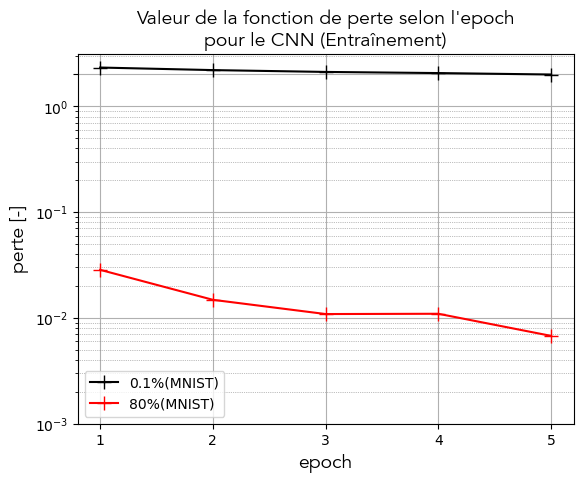

In [25]:
# CNN - 0.1 et 80% des données
#Graphique pour perte à l'entraînement (epoch)
data_01=np.array(train_losses[0:5])
data_80=np.array(train_losses[25:31])
# print(data_01[:])
# print(data_80[:])

#GRAPH - ENTRAÎNEMENT
plt.plot(data_01[:,0],data_01[:,1],label="0.1%(MNIST)",color='black',marker='+',markersize=10)
plt.plot(data_80[:,0],data_80[:,1],label="80%(MNIST)",color='red',marker='+',markersize=10)
plt.yscale('log')
plt.title('Valeur de la fonction de perte selon l\'epoch\npour le CNN (Entraînement)', font='Avenir', size=14)
plt.xlabel("epoch", font='Avenir', size=14)
plt.ylabel("perte [-]", font='Avenir', size=14)
plt.legend()
plt.grid()
plt.xticks([1,2,3,4,5])
plt.yticks([0.001,0.01,0.1,1,2])
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')  # Grille mineure
plt.savefig(f"./figures/p1e5_TrainLoss.png",dpi=150)
plt.show()

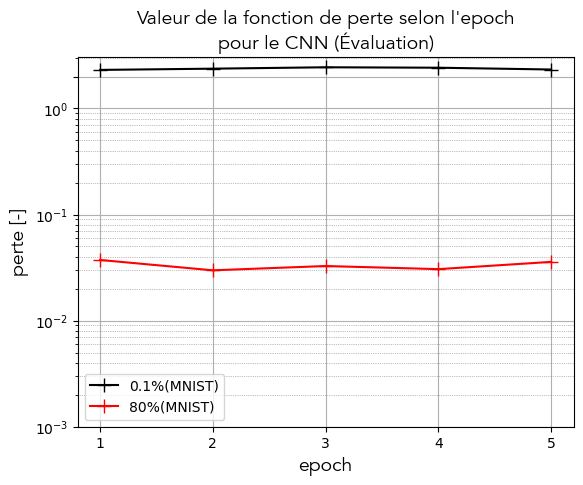

In [26]:
# CNN - 0.1 et 80% des données
#Graphique pour perte à l'évaluation (epoch)
data_01=np.array(test_losses[0:5])
data_80=np.array(test_losses[25:31])
# print(data_01[:])
# print(data_80[:])

#GRAPH - ÉVALUATION
plt.plot(data_01[:,0],data_01[:,1],label="0.1%(MNIST)",color='black',marker='+',markersize=10)
plt.plot(data_80[:,0],data_80[:,1],label="80%(MNIST)",color='red',marker='+',markersize=10)
plt.yscale('log')
plt.title('Valeur de la fonction de perte selon l\'epoch\npour le CNN (Évaluation)', font='Avenir', size=14)
plt.xlabel("epoch", font='Avenir', size=14)
plt.ylabel("perte [-]", font='Avenir', size=14)
plt.legend()
plt.grid()
plt.xticks([1,2,3,4,5])
plt.yticks([0.001,0.01,0.1,1,2])
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')  # Grille mineure
plt.savefig(f"./figures/p1e5_TestLoss.png",dpi=150)
plt.show()

## LIN

In [27]:
# print(train_lossesLin)
# print(len(train_lossesLin))

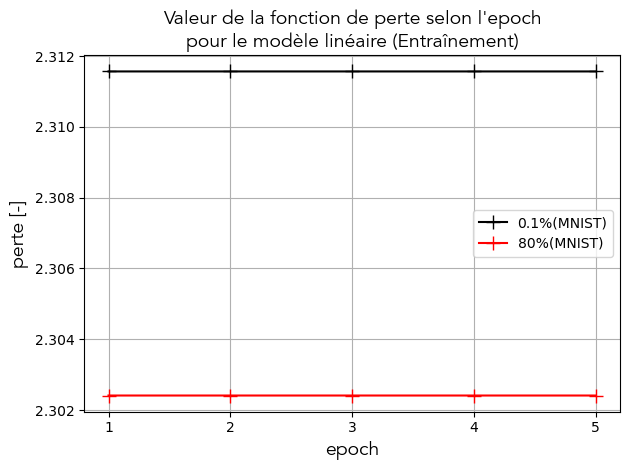

In [28]:
# Lin - 0.1 et 80% des données
#Graphique pour perte à l'entraînement (epoch)
data_01Lin=np.array(train_lossesLin[0:5])
data_80Lin=np.array(train_lossesLin[5:11])


#GRAPH - ENTRAÎNEMENT
plt.plot(data_01Lin[:,0],data_01Lin[:,1],label="0.1%(MNIST)",color='black',marker='+',markersize=10)
plt.plot(data_80Lin[:,0],data_80Lin[:,1],label="80%(MNIST)",color='red',marker='+',markersize=10)
# plt.yscale('log')
plt.title('Valeur de la fonction de perte selon l\'epoch\npour le modèle linéaire (Entraînement)', font='Avenir', size=14)
plt.xlabel("epoch", font='Avenir', size=14)
plt.ylabel("perte [-]", font='Avenir', size=14)
plt.legend()
plt.grid()
plt.xticks([1,2,3,4,5])
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')  # Grille mineure
plt.tight_layout()
plt.savefig(f"./figures/p1e5_TrainLossLin.png",dpi=150)
plt.show()

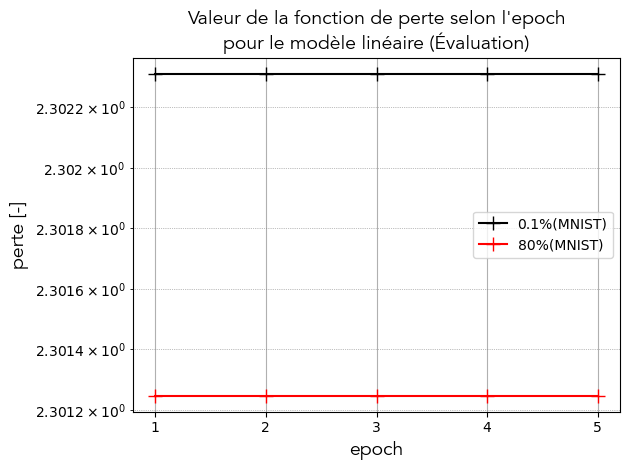

In [29]:
# Lin - 0.1 et 80% des données
#Graphique pour perte à l'évaluation (epoch)
data_01Lin=np.array(test_lossesLin[0:5])
data_80Lin=np.array(test_lossesLin[5:11])


#GRAPH - ENTRAÎNEMENT
plt.plot(data_01Lin[:,0],data_01Lin[:,1],label="0.1%(MNIST)",color='black',marker='+',markersize=10)
plt.plot(data_80Lin[:,0],data_80Lin[:,1],label="80%(MNIST)",color='red',marker='+',markersize=10)
plt.yscale('log')
plt.title('Valeur de la fonction de perte selon l\'epoch\npour le modèle linéaire (Évaluation)', font='Avenir', size=14)
plt.xlabel("epoch", font='Avenir', size=14)
plt.ylabel("perte [-]", font='Avenir', size=14)
plt.legend()
plt.grid()
plt.xticks([1,2,3,4,5])
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray') # Grille mineure
plt.tight_layout()
plt.savefig(f"./figures/p1e5_TestLossLin.png",dpi=150)
plt.show()

## 6 - Courbes ROC - fonction

In [107]:
def global_conf_mx(ps_dict):
    global_ps_mx={}
    for key in ps_dict.keys():
        TPsum=0
        TNsum=0
        FPsum=0
        FNsum=0
        # Somme de chaque score pour l'ensemble des classes, 
        # après l'entraînement à 80% de l'échantillon
        for n in ps_dict[key]['c'].values():
            TPsum+=n['TP']
            TNsum+=n['TN']
            FPsum+=n['FP']
            FNsum+=n['FN']
        global_ps_mx[key]={'TP':TPsum,'TN':TNsum,'FP':FPsum,'FN':FNsum}
    
    return global_ps_mx

In [108]:
global_conf_mx(percent_scoresLIN)

{0.1: {'TP': 5363, 'TN': 436883, 'FP': 48577, 'FN': 48577},
 80: {'TP': 616, 'TN': 48616, 'FP': 5384, 'FN': 5384}}

In [133]:
#Fonction de courbe adaptée aux sorties des tests avec matrices de confusion
def ROC_curve_fn(percent_score,nclass,aimodel):
    k=percent_score.keys()
    mxKey="c"
    points=[[100,0]]
    for sample in k:
        conf_mx=percent_score[sample][mxKey][nclass]
        Rp=100*conf_mx['TP']/(conf_mx['TP']+conf_mx['FN']) #Taux de TP dans les y
        Rn=100*conf_mx['TN']/(conf_mx['TN']+conf_mx['FP']) #Taux de TN dans les x
        points.append([Rn,Rp]) #(Spécificité, Sensitivité)
    points.append([0,100])
    points=np.array(points)
    points=points[np.argsort(points[:, 0])]
    #PLOT
    fillcolors={"CNN":'lightblue',"LIN":'red'}
    #Données et aires
    plt.xlim(0,100)
    plt.plot(points[:,0],points[:,1], color="black",marker="^")
    plt.fill_between(points[:,0], points[:,1],color=fillcolors[aimodel], alpha=0.4)
    
    
    plt.gca().invert_xaxis()
    plt.ylim(0, 100)  # Fix y-axis from 0 to 100

    #Titres
    plt.xlabel('Spécificité [%]', font="Avenir", size=14)
    plt.ylabel('Sensitivité [%]', font="Avenir", size=14)
    plt.title(f'Courbe ROC ({aimodel})\n classe : {nclass}', font="Avenir", size=14)
    
    #Sauvegarde et affichage
    plt.tight_layout()
    plt.savefig(f"./figures/p1e6_ROC-{aimodel}-{nclass}.png", dpi=150)
    plt.show()


In [123]:
global_conf_mx(percent_scores)

{0.1: {'TP': 8933, 'TN': 440453, 'FP': 45007, 'FN': 45007},
 1: {'TP': 46214, 'TN': 473414, 'FP': 7186, 'FN': 7186},
 10: {'TP': 46578, 'TN': 430578, 'FP': 1422, 'FN': 1422},
 20: {'TP': 41295, 'TN': 377295, 'FP': 705, 'FN': 705},
 50: {'TP': 23759, 'TN': 215759, 'FP': 241, 'FN': 241},
 80: {'TP': 5958, 'TN': 53958, 'FP': 42, 'FN': 42}}

In [134]:
#Fonction de courbe pour les sorties de la fonction global_conf_mx
def ROC_curve_global(conf_mx_dict, aimodel):
    points=[[100,0]]
    for mx in conf_mx_dict.values():
        Rp=100*mx['TP']/(mx['TP']+mx['FN']) #Taux de TP dans les y
        Rn=100*mx['TN']/(mx['TN']+mx['FP']) #Taux de TN dans les x
        points.append([Rn,Rp]) #(Spécificité, Sensitivité)
        
    points.append([0,100])
    points=np.array(points)
    points[np.argsort(points[:, 0])]
    
    #PLOT
    #Données et aires
    fillcolors={"CNN":'lightblue',"LIN":'red'}
    plt.xlim(0,100)
    plt.plot(points[:,0],points[:,1], color="black",marker="^")
    plt.fill_between(points[:,0], points[:,1], color=fillcolors[aimodel], alpha=0.4)
    
    
    plt.gca().invert_xaxis()
    plt.ylim(0, 100)  # Fix y-axis from 0 to 100

    #Titres
    plt.xlabel('Spécificité [%]', font="Avenir", size=14)
    plt.ylabel('Sensitivité [%]', font="Avenir", size=14)
    plt.title(f'Courbe ROC ({aimodel})\n global', font="Avenir", size=14)
    
    #Sauvegarde et affichage
    plt.tight_layout()
    plt.savefig(f"./figures/p1e6_ROCglobal-{aimodel}.png", dpi=150)
    plt.show()
    

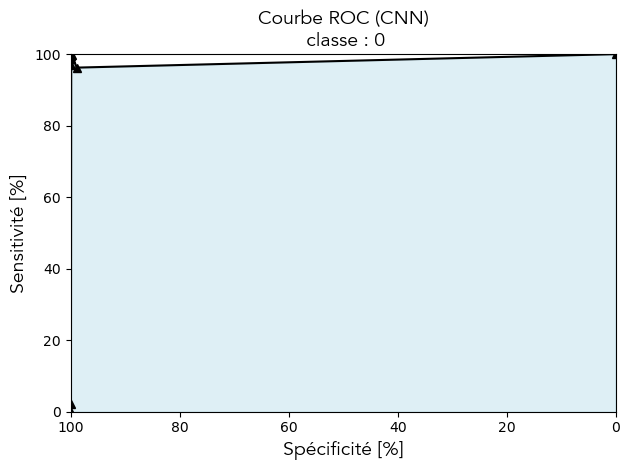

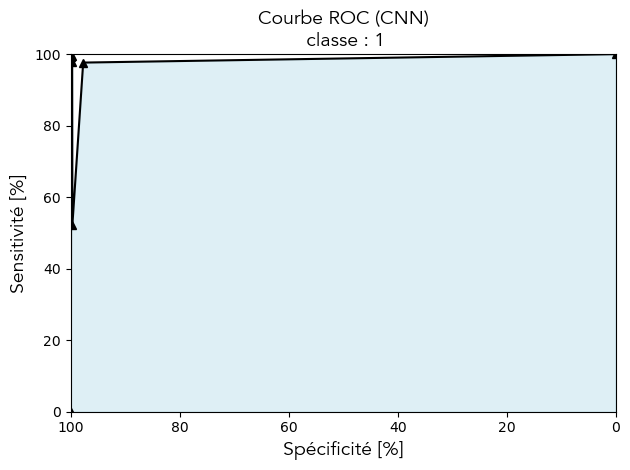

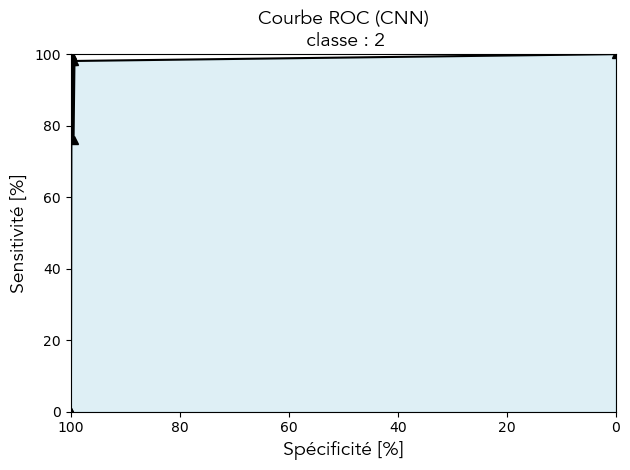

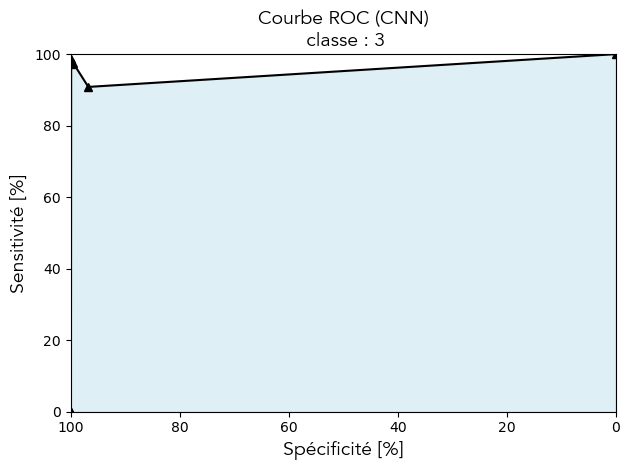

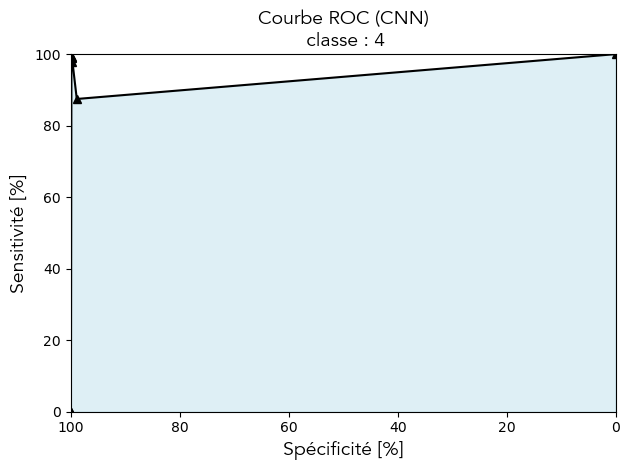

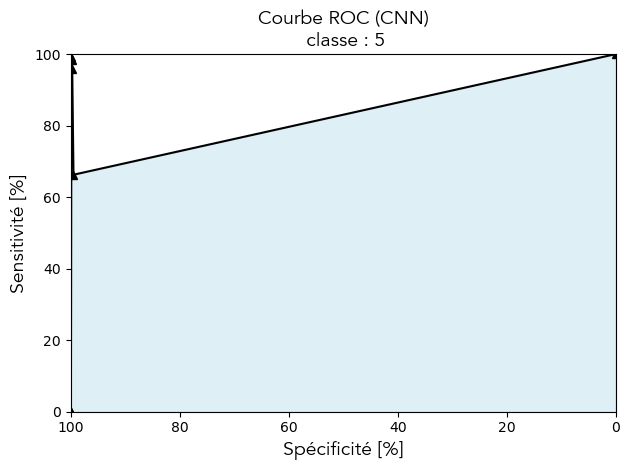

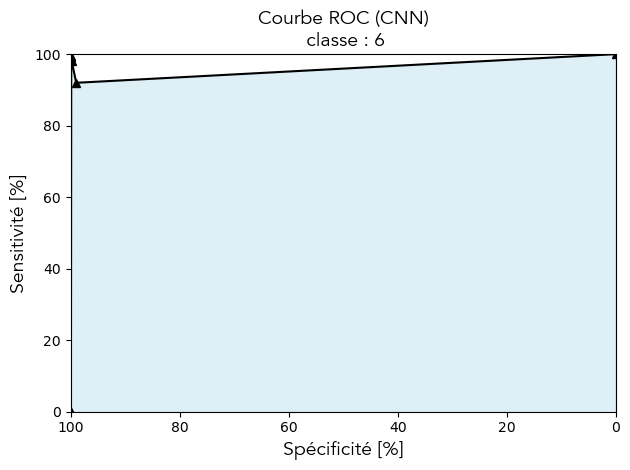

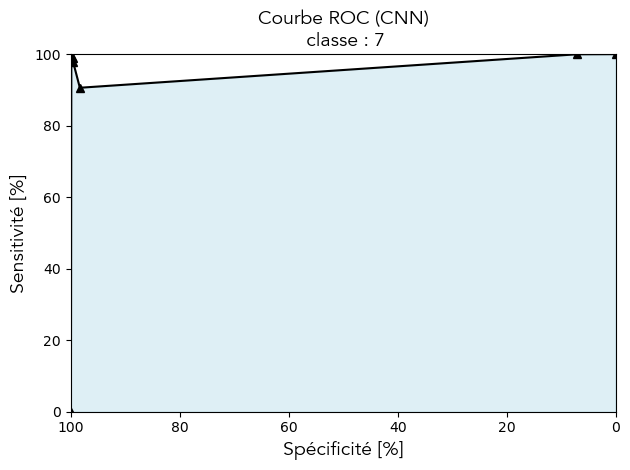

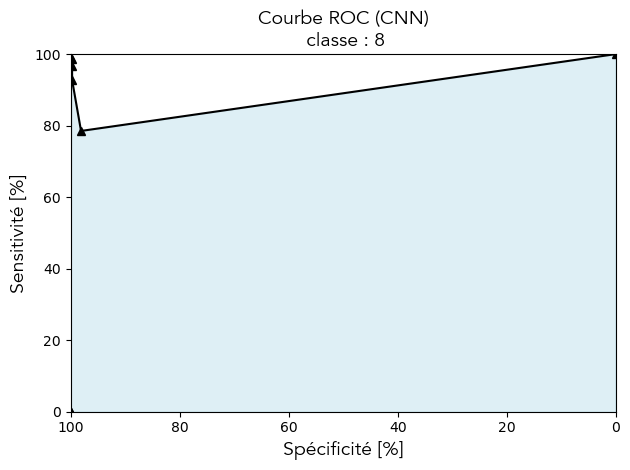

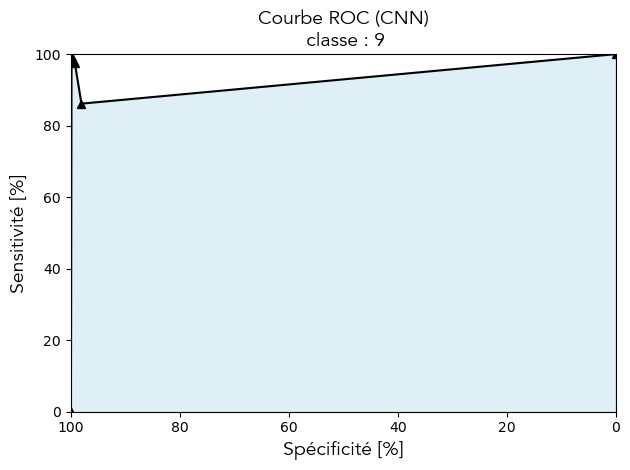

In [135]:
#COURBES ROC pour le CNN
for classnumber in range(10):
    ROC_curve_fn(percent_scores,classnumber,"CNN")

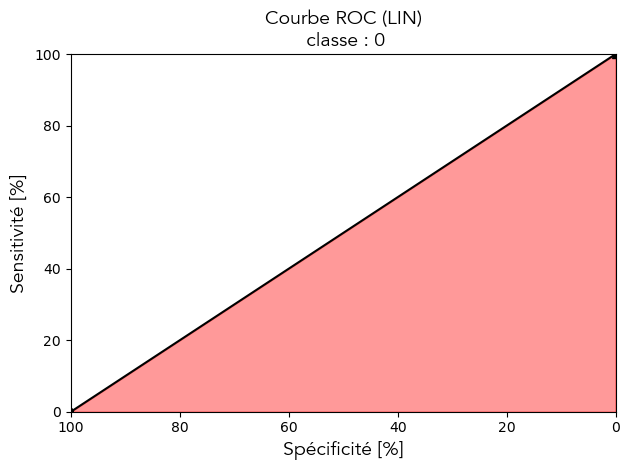

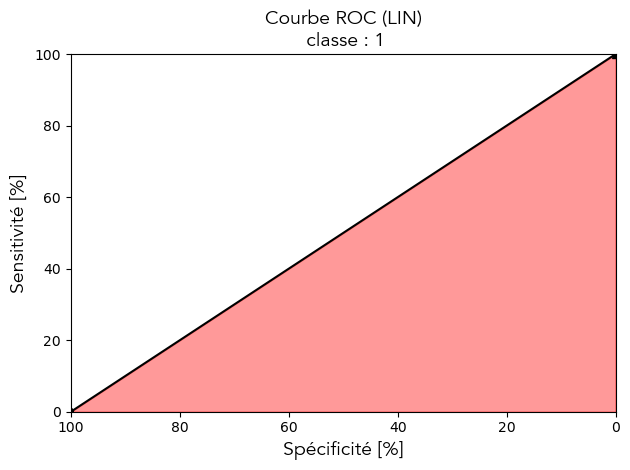

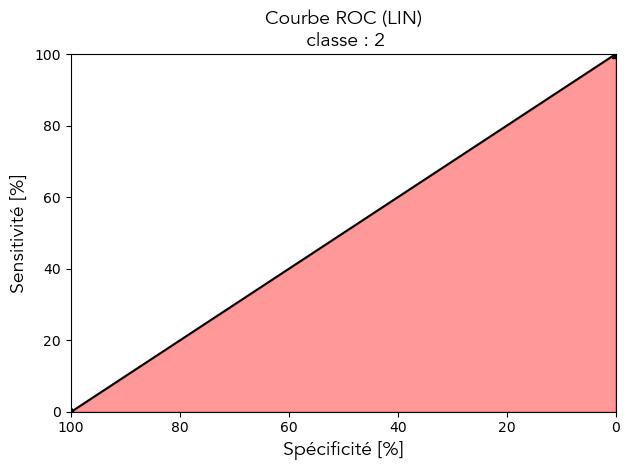

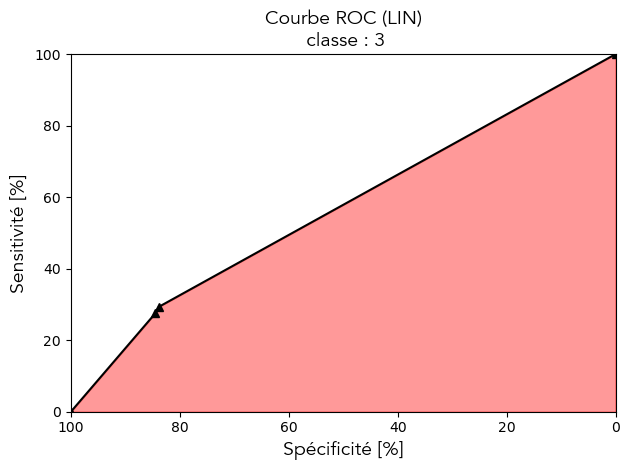

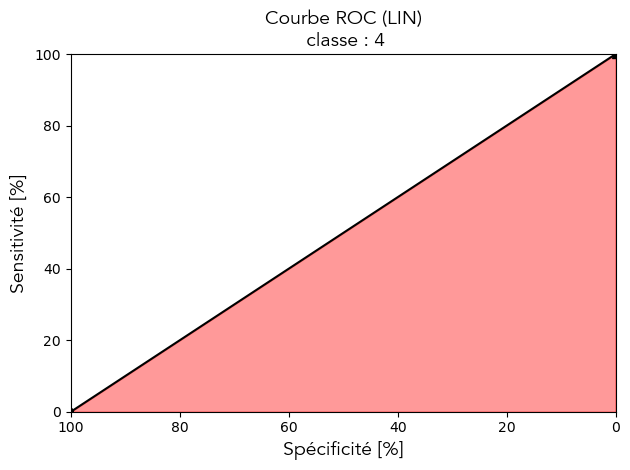

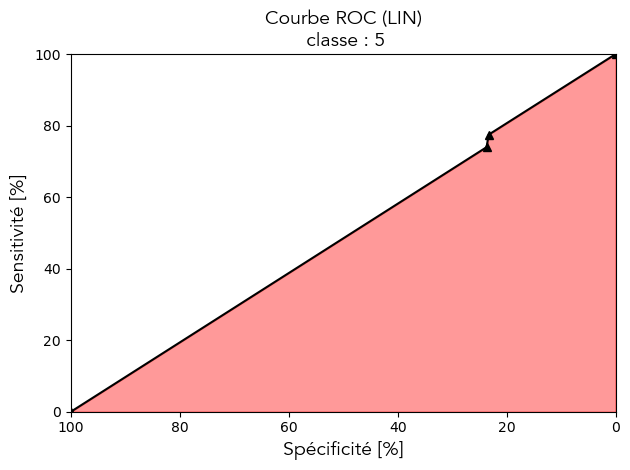

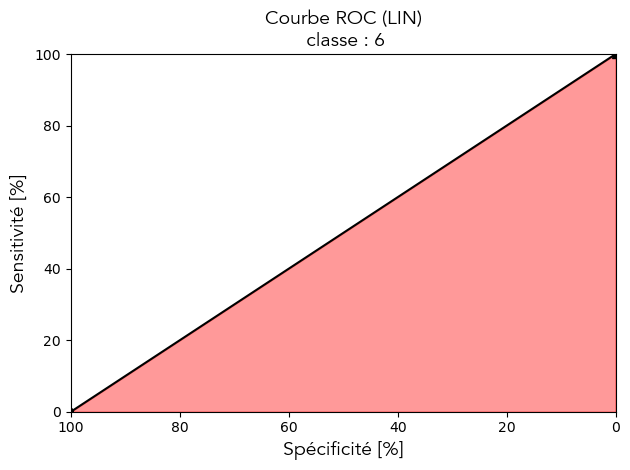

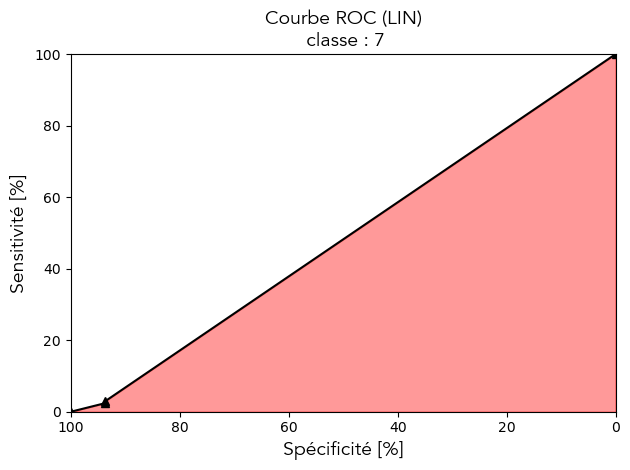

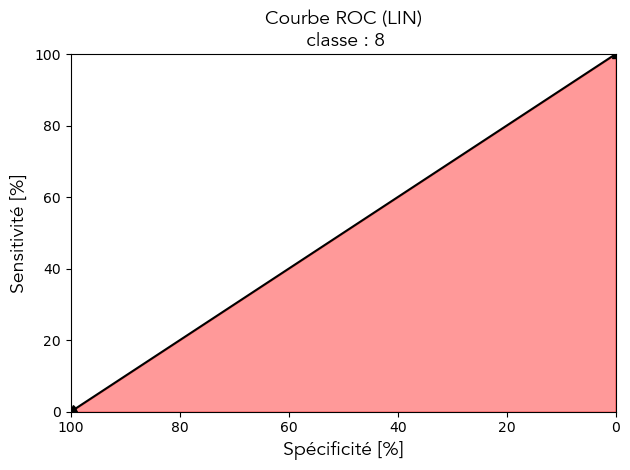

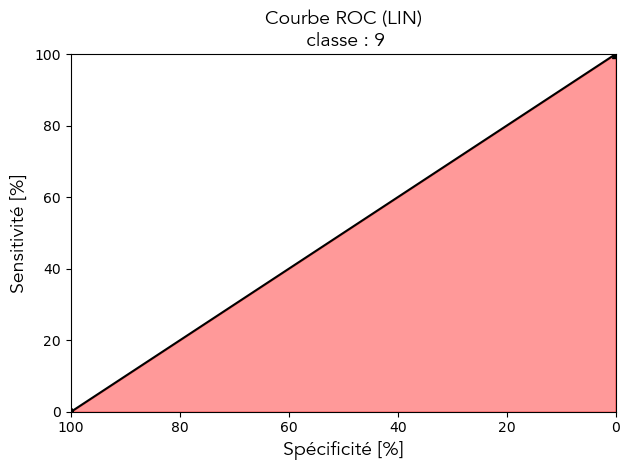

In [136]:
#COURBES ROC pour le LIN
for classnumber in range(10):
    ROC_curve_fn(percent_scoresLIN,classnumber,"LIN")

## 7 - Matrices de confusion
#### Pour 2 avec CNN, et 3 avec LIN

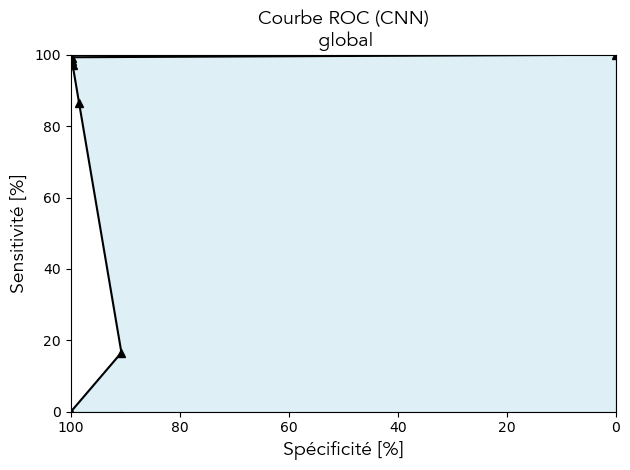

In [137]:
ROC_curve_global(global_conf_mx(percent_scores), "CNN")

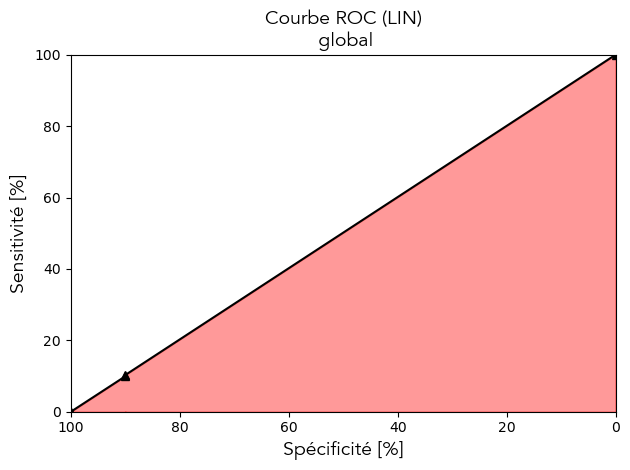

In [138]:
ROC_curve_global(global_conf_mx(percent_scoresLIN), "LIN")

In [121]:
global_conf_mx(percent_scores)

{0.1: {'TP': 8933, 'TN': 440453, 'FP': 45007, 'FN': 45007},
 1: {'TP': 46214, 'TN': 473414, 'FP': 7186, 'FN': 7186},
 10: {'TP': 46578, 'TN': 430578, 'FP': 1422, 'FN': 1422},
 20: {'TP': 41295, 'TN': 377295, 'FP': 705, 'FN': 705},
 50: {'TP': 23759, 'TN': 215759, 'FP': 241, 'FN': 241},
 80: {'TP': 5958, 'TN': 53958, 'FP': 42, 'FN': 42}}

## FIGURE BONUS

#### 1) Colormaps des tables de contingence pour les 6 tailles d'échantillons du modèle

In [185]:
def failed_score(cont_table):
    total = cont_table.sum()
    diag=np.diag(cont_table)
    diag_sum=diag.sum()
    return (1-(diag_sum/total))*100

In [244]:
def cont_tb_colormap(array,ksize):
    # [%] des valeurs non-présentes sur la diagonales
    fail=round(failed_score(array),1)
    #Normalisation des valeurs en %
    norm_array=(array/array.sum())
    array = np.log(norm_array)
    
    # Create the color map
    plt.figure(figsize=(8, 6))
    im = plt.imshow(array, cmap='magma_r', interpolation='nearest')

    # Add a colorbar linked to the current axis
    cbar = plt.colorbar(im, ax=plt.gca())
    cbar.set_label(r"$\log[s]$",
                   rotation=-90, labelpad=15,font='Times New Roman', size=16)
     # Ajouter le carré blanc à la légende
    legend_patch = patches.Patch(facecolor='white', edgecolor='black', label='0')
    cbar.ax.legend(handles=[legend_patch], loc='lower left', bbox_to_anchor=(-0.2, -0.1))

    
    
    # Set ticks and labels for both axes
    values_range = [str(i) for i in range(10)]
    plt.xticks(ticks=np.arange(10), labels=values_range, size=16)
    plt.yticks(ticks=np.arange(10), labels=values_range, size=16)
    
    
    # Ajouter des titres et étiquettes
    plt.title(f"Table de contingence des prédictions\nmodèle CNN, {ksize}% de la BD, {fail}% d'échec",
             font='Avenir', size=16)
    plt.xlabel("Prédictions",font='Avenir', size=16)
    plt.ylabel("Vérité",font='Avenir', size=16)
#     plt.set_xticklabels(values_range)
#     plt.set_yticklabels(values_range)
    # Afficher le graphique
    plt.tight_layout()
    plt.savefig(f"./figures/bonusfig_{ksize}pop.png",dpi=150)
    plt.show()

/var/folders/md/1dwvntds2zg_1yzwwp8232zm0000gn/T/ipykernel_84019/1475832314.py:6: RuntimeWarning: divide by zero encountered in log
  array = np.log(norm_array)


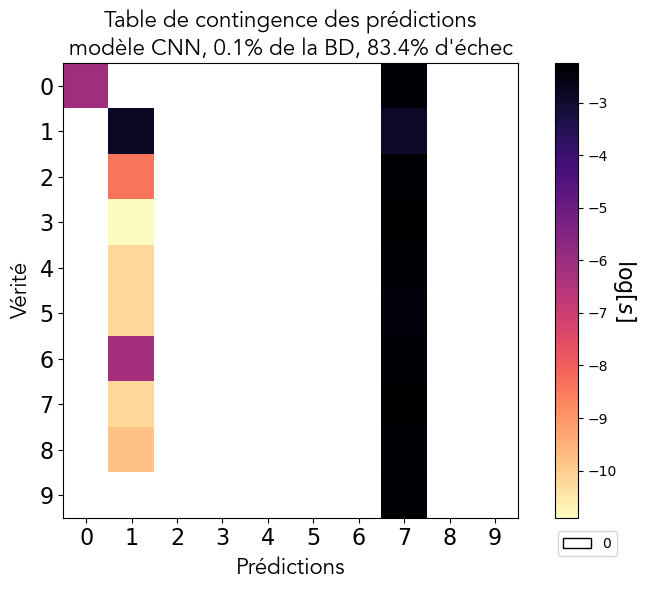

/var/folders/md/1dwvntds2zg_1yzwwp8232zm0000gn/T/ipykernel_84019/1475832314.py:6: RuntimeWarning: divide by zero encountered in log
  array = np.log(norm_array)


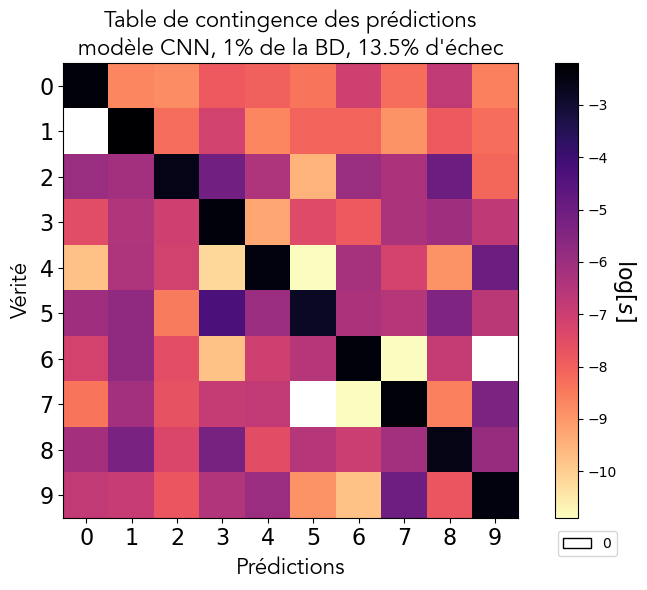

/var/folders/md/1dwvntds2zg_1yzwwp8232zm0000gn/T/ipykernel_84019/1475832314.py:6: RuntimeWarning: divide by zero encountered in log
  array = np.log(norm_array)


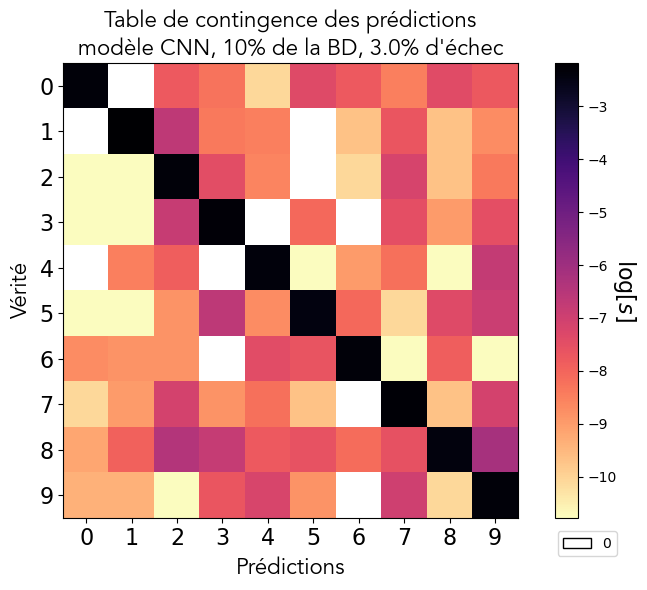

/var/folders/md/1dwvntds2zg_1yzwwp8232zm0000gn/T/ipykernel_84019/1475832314.py:6: RuntimeWarning: divide by zero encountered in log
  array = np.log(norm_array)


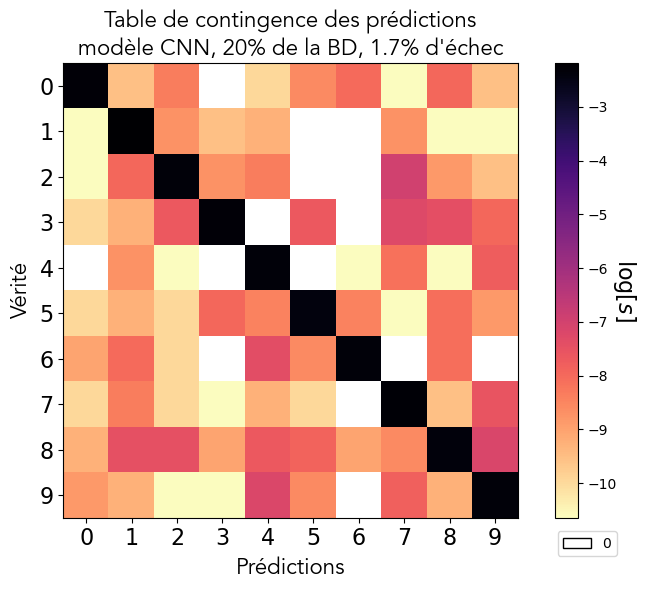

/var/folders/md/1dwvntds2zg_1yzwwp8232zm0000gn/T/ipykernel_84019/1475832314.py:6: RuntimeWarning: divide by zero encountered in log
  array = np.log(norm_array)


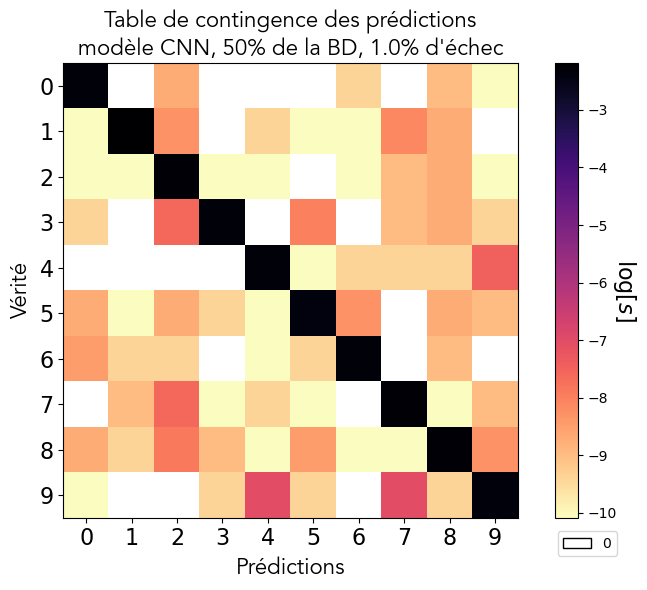

/var/folders/md/1dwvntds2zg_1yzwwp8232zm0000gn/T/ipykernel_84019/1475832314.py:6: RuntimeWarning: divide by zero encountered in log
  array = np.log(norm_array)


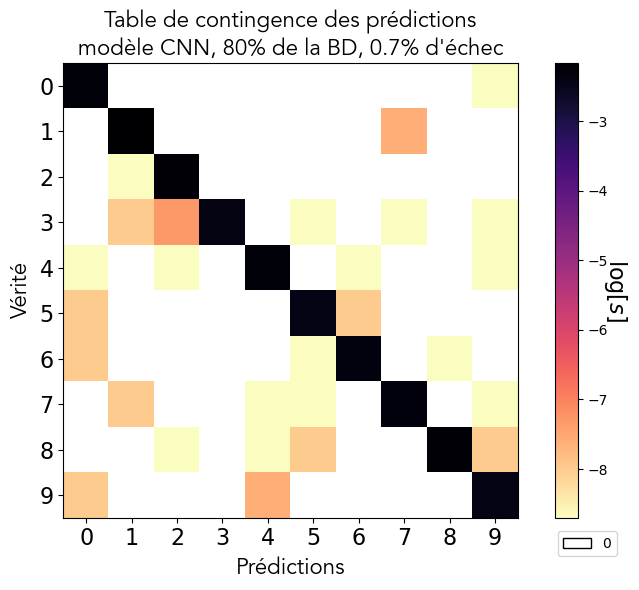

In [245]:
for ksize in [0.1,1,10,20,50,80]:
    cont_tb_colormap(percent_scores[ksize]["m"],ksize)

In [ ]:
# Training loop
num_epochs = 5
best_test_accuracy = 0.0  # To track the best test accuracy
best_epoch = 0  # To track the epoch with the best test accuracy

for epoch in range(num_epochs):
    # Train the model
    train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
    
    # Evaluate on the test set during training
    test_loss, test_accuracy = test(model, test_loader, criterion, DEVICE)
    
    # Update the best model if the current test accuracy is better
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    
    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Best Test Accuracy So Far: {best_test_accuracy:.2f}% (Epoch {best_epoch})")

# Load the best model for final validation evaluation
print("\nLoading the best model for validation...")
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate the final model on the validation set
validation_loss, validation_accuracy = test(model, val_loader, criterion, DEVICE)
print(f"\nFinal Validation Results - Loss: {validation_loss:.4f}, Accuracy: {validation_accuracy:.2f}%")

# CODE EXEMPLE (Inclus dans TP)

In [ ]:
# Step 3: Split into Train/Validation/Test
train_size = int(0.8 * len(full_dataset))  # 80% training
val_size = int(0.1 * len(full_dataset))    # 10% validation
test_size = len(full_dataset) - train_size - val_size  # 10% test
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Step 4: Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 5: Verify the Split
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

In [ ]:
# Get a batch from the test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)
sample_image = images[0]
sample_label = labels[0]

print(f"Batch shape: {images.shape}")
print(f"Sample image shape: {sample_image.shape}")
print(f"Sample label: {sample_label}")

In [ ]:
# # Classifier model with linear layers only
# class LinearClassifier(nn.Module):
#     def __init__(self):
#         super(LinearClassifier, self).__init__()
#         # Flatten the 28x28 input to a single vector of 784
#         self.fc1 = nn.Linear(28 * 28, 512)  # Input layer
#         self.fc2 = nn.Linear(512, 256)  # Hidden layer 1
#         self.fc3 = nn.Linear(256, 128)  # Hidden layer 2
#         self.fc4 = nn.Linear(128, 10)   # Output layer (10 classes)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # Flatten the input
#         x = F.relu(self.fc1(x))   # First linear layer
#         x = F.relu(self.fc2(x))   # Second linear layer
#         x = F.relu(self.fc3(x))   # Third linear layer
#         x = self.fc4(x)           # Output logits
#         return x

# model = LinearClassifier().to(DEVICE)
# print(model)

# Classifier model with CNN
class SimpleClassifier(nn.Module):
    
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Update dimensions if pooling changes output size
        self.fc2 = nn.Linear(128, 10)  # 10 classes (0–9)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + Pool
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Logits
        return x

model = SimpleClassifier().to(DEVICE)
print(model)

In [ ]:
# Training the classifier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        #if (batch_idx + 1) % 100 == 0:
        #    print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

In [ ]:
# Training loop
num_epochs = 5
best_test_accuracy = 0.0  # To track the best test accuracy
best_epoch = 0  # To track the epoch with the best test accuracy

for epoch in range(num_epochs):
    # Train the model
    train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
    
    # Evaluate on the test set during training
    test_loss, test_accuracy = test(model, test_loader, criterion, DEVICE)
    
    # Update the best model if the current test accuracy is better
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    
    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Best Test Accuracy So Far: {best_test_accuracy:.2f}% (Epoch {best_epoch})")

# Load the best model for final validation evaluation
print("\nLoading the best model for validation...")
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate the final model on the validation set
validation_loss, validation_accuracy = test(model, val_loader, criterion, DEVICE)
print(f"\nFinal Validation Results - Loss: {validation_loss:.4f}, Accuracy: {validation_accuracy:.2f}%")

In [ ]:
# Model inference
#sample_image = sample_image.unsqueeze(0)  # Add batch dimension for the model
outputs = model(images)  # Forward pass
predicted_class = torch.argmax(outputs[0])
print(f"Predicted class: {predicted_class}")

# Visualize the second image in the batch
plt.imshow(images[0][0].numpy() * 0.5 + 0.5, cmap='gray')  # Unnormalize for visualization
plt.title(f"Label: {labels[0]}")
plt.show()